# INF 5520 Mandatory term project 2021 - part II

# Feature evaluation and classification


In this mandatory exercise you are going to implement a multivariate Gaussian classifier and use it to classifiy images with 4 different texture classes. You must implement your own classifier, but you are allowed to use library functions to invert matrixes, compute the determinant, and compute the mean vector and the covariance matrix for each class. It is recommended that you use an environment where you have access to a numerically stable library function for matrix inversion (for example Matlab).

The exercise combines feature evaluation, classifier implementation, training a classifier, testing different feature combinations and evaluating classifier performance.

### Submission through notebook
If you submit using a Jupyter notebook, you notebook MUST contain discussion of the required aspect, figures, code, and discussion of what the figures show. Create a zip-file of all materials and check that it displays correctly if downloaded from a differnet directory.  The format of the text should be like what you find in a techinical report.

### Time table:
• Exercise and images available: Monday October 19, 2020
• Deadline for Part II:  Monday November 9, 2020

### Submission:
Your solution should be submitted as a single PDF file contraining the problem descrition, discussion, and supporting source code. The files should be compressed (.zip or .tar) in a folder names YOURUSERNAME_PARTII.zip/tar and upload it through the devilry system (devilry.ifi.uio.no) before the deadline above. Questions about the submission can be directed to the group teacher.

If you submit a notebook, you do not need to include all the original texture images, but make sure to include any result figures or illustions on .png-format.

### Evaluation:
Since image processing is a field where solutions often are found by experimenting
with different methods, we would like to emphasize the following point: You will be
credited for analyzing the problem and the input images so you can select suitable
methods and features. You will not be credited for testing all available
methods/features, even if it is a huge amount of work. Analysis and discussion, of
both input and output, are very important. Please note that both mandatory exercises must be passed in order to take the exam.

### How to work
The exercise is an individual work, and each student should deliver a written report. Your report should be genuine, in particular we will check that each report provides its own discussion of all method and parameter choices. Include references if you use external sources.
The report should contain the description of the problem, theory, chosen methods, results and algorithms used. You have to document all steps in the algorithms, and listings of our own code should be included as appendix. The code for your classification algorithm should be listed in your report.
Remark: Part II is not linked directly to part I, so you will work on new feature images. These will be input to multivariate classification, not thresholded as in part I. 

### The image data set

#### Python comment: png-version of the dataset is found under …/undervisningsmateriale/mandatory2/oblig2-python.zip
Note that the png-format does not handle the scaling of the glcm-images well, thus we work either directly by reading matlab-files or text/ascii-files into python.

You have available a separate training data set and a test data set of three original images and a set of precomputed GLCM matrices computed from the training image.
The images can be found under …/undervisningsmateriale/mandatory2/oblig2_python.zip . 

(File extention .txt for text files)
Training data set:
mosaic1_train.mat
training_mask.mat
                                                                 For each texture: 
texture1_glcmdx0dymin1.mat	 	Angle 90 degrees x, y-1
texture1_glcmdxplus1dy0.mat                 Angle 0     x+1,y
texture1_glcmdxplus1dymin1.mat          Angle 45 x+1,y-1
  texture1_glcmdxmin1dymin1.mat           Angle 135 x-1,y-1
texture2_glcmdx0dymin1.mat            .
texture2_glcmdxplus1dy0.mat
texture2_glcmdxplus1dymin1.mat
texture2_glcmdxmin1dymin1.mat
texture3_glcmdx0dymin1.mat
texture3_glcmdxplus1dy0.mat
texture3_glcmdxplus1dymin1.mat
texture3_glcmdxmin1dymin1.mat
texture4_glcmdx0dymin1.mat
texture4_glcmdxplus1dy0.mat
texture4_glcmdxplus1dymin1.mat
texture4_glcmdxmin1dymin1.mat

Test data set:
mosaic2_test.mat with mask mask_mosaic2_test.mat 
mosaic3_test.mat with mask mask_mosaic3_test.mat

### Task overview

The task has the following steps
1. Choosing glcm images to work with.
2. Discussing new features by subdividing the GLCM matrices
3. Selecting and implementing the best features from the GLCM matrices
4. Implementing a Gaussian classifier
5. Training the classifier on the chosen features
6. Classifying the test images. Compute the classification accuracy and           confusion matrices and discuss the performance of the classification

Your report should contain one section for each of these 6 tasks. 



## 1. Choosing GLCM images to work with


mosaic1_train.mat contains 4 differenttextures (texture1,…texture4). A subimage of each texture was used to precompute GLCM matrices as you did in Part I. GLCM matrices with distances $(\Delta x=1,\Delta y=0), (\Delta x=0, \Delta y=-1), (\Delta x=1, \Delta y=-1) and (\Delta x=-1, \Delta y=-1)$ for each texture, and G=16. These GLCM images are given above. 
Analyze the GLCM matrices given and select maximum two directions that you expect to be useful for discriminating the textures. Discuss if you need one or two directions, and discuss which directions you think have most information. 

Your answer should contain both a discussion and figures to support you discussion. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import glob
import pathlib
from numba import jit
# %matplotlib widget

#Find path to each txt file
path = str(pathlib.Path().resolve())
glcm_files = sorted([name.split("/")[-1] for name in glob.glob(path+"/text*")])


#Create lists for each texture
glcm_dx0_dymin1 = list()
glcm_dx0_dymin1_names =list()

glcm_dx1_dy0 = list()
glcm_dx1_dy0_names = list()

glcm_dx1_dymin1 = list()
glcm_dx1_dymin1_names = list()

glcm_dxmin1_dymin1 = list()
glcm_dxmin1_dymin1_names = list()


#Convert from txt to numpy
for f in glcm_files:
    if "dx0dymin1" in f:
        glcm_dx0_dymin1.append(np.loadtxt(f, dtype=int, delimiter=','))
        glcm_dx0_dymin1_names.append(f)
    if "dx1dy0" in f:
        glcm_dx1_dy0.append(np.loadtxt(f, dtype=int, delimiter=','))
        glcm_dx1_dy0_names.append(f)
    if "dx1dymin1" in f:
        glcm_dx1_dymin1.append(np.loadtxt(f, dtype=int, delimiter=','))
        glcm_dx1_dymin1_names.append(f)
    if "dxmin1dymin1" in f:
        glcm_dxmin1_dymin1.append(np.loadtxt(f, dtype=int, delimiter=','))
        glcm_dxmin1_dymin1_names.append(f)       

In [2]:
def visualize_glcm(glcm, glcm_name, dx, dy):
    fig, axs = plt.subplots(2,2)
    
    fig.suptitle(f"dx = {dx}, dy = {dy}")

    h0 = sn.heatmap(glcm[0], ax=axs[0,0])
    h0.set_title(glcm_name[0])
    h0.axis('off')

    h1 = sn.heatmap(glcm[1],ax=axs[0,1])
    h1.set_title(glcm_name[1])
    h1.axis('off')

    h2 = sn.heatmap(glcm[2],ax=axs[1,0])
    h2.set_title(glcm_name[2])
    h2.axis('off')

    h3 = sn.heatmap(glcm[3],ax=axs[1,1])
    h3.set_title(glcm_name[3])
    h3.axis('off')

    plt.show()

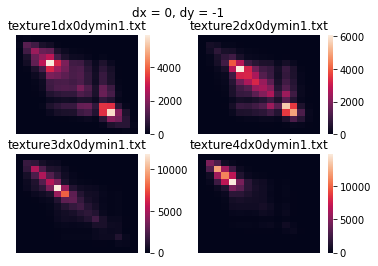

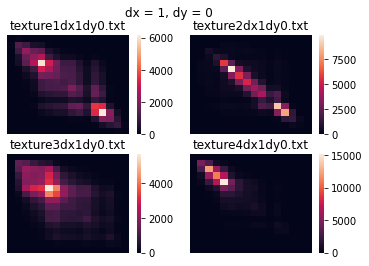

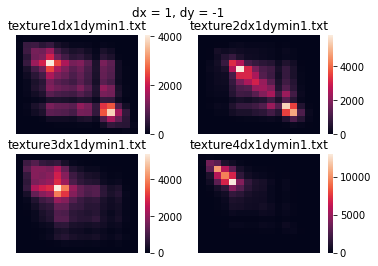

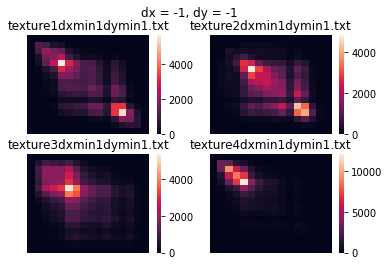

In [3]:
visualize_glcm(glcm_dx0_dymin1, glcm_dx0_dymin1_names, dx=0, dy=-1)
visualize_glcm(glcm_dx1_dy0, glcm_dx1_dy0_names, dx=1, dy=0)
visualize_glcm(glcm_dx1_dymin1, glcm_dx1_dymin1_names, dx=1, dy=-1)
visualize_glcm(glcm_dxmin1_dymin1, glcm_dxmin1_dymin1_names, dx=-1, dy=-1)

### Discussing the GLCM results from given txt files
To best differentiate between different textures using GLCM's, we ideally want 4 completely different GLCM matrices. In the above figures i have plotted the glcm for each texture using the given direction. 

- Analysing glcm's produced with dx=0 and dy=-1 one can observe that the glcm for texture 1 and 2 are quite similar, there are some similarites between texture 3 and 4 but no to the same extent.

- Analysing glcm's produced with dx=1 and dy = 0 one can observe that these parameters creates four different glcm's. I would argue that this is a parameter suitable to differenciate all textures.

- Moreover the glcm's produced with dx = 1 and dy = -1 as well as dx=-1 and dy =-1 are not all unique. For the dx=1 and dy = -1 case texture 1 and 2 are similar. Additionally for dx=-1 and dy=-1 texture 1 and 2 are similar.

With this i conclude that it is sufficient to use only one direction, which is dx=1 and dy = 0.

## 2. Discussing new features by subdividing the GLCM matrices

In this exercise you should NOT use any of the GLCM features from the lectures, but
implement your own features that are based on only parts of the GLCM matrices, not the entire matrix. Divide the 16x16 GLCM (G=16) matrix into four quadrants Q1, Q2, Q3 and Q4 of the same size. Create new features by summing the amount of energy/percentage of gray level transitions found in each quadrant, e.g.

\begin{align}
Q1=\frac{\sum_{i=1}^{8}\sum_{j=1}^{8}P(i,j)}{\sum_{i=1}^{G}\sum_{j=1}^{G}P(i,j)} 
\end{align}

\begin{align}
Q2=\frac{\sum_{i=1}^{8}\sum_{j=9}^{G}P(i,j)}{\sum_{i=1}^{G}\sum_{j=1}^{G}P(i,j)} 
\end{align}
 
Features Q3 and Q4 should be computed correspondingly.

Based on just visual inspection of the selected GLCM matrices, discuss if you think all four textures can be separated with these features. If you do not think the textures can be separated using a subdivision into 4 quadrants, you can subdivide ONE of the quadrants into 4 smaller quadrants of equal size. If you choose to do this, discuss which quadrant you should subdivide.

How many quadrants do you need do discriminate between the four textures? 


In [4]:
#Assuming we use the glcm's produced with dx = 1 and dy = 0
glcm = glcm_dx1_dy0.copy()
glcm_names = glcm_dx1_dy0_names.copy()

#Function that finds all the quadrants
#The function also subdivdes Q1 into smaller quadrants
def all_quadrants(glcm):
    norm = (np.sum(glcm[:8,:8])+np.sum(glcm[8:,:8])+np.sum(glcm[8:,8:]))

    sub = glcm[:8,:8]
    res=np.array([np.sum(sub[:4,:4]), np.sum(sub[:4,4:]), np.sum(sub[4:,:4]), np.sum(sub[4:,4:])])/np.sum(sub)
    q1_1 = res[0]
    q1_2 = res[1]
    q1_3 = res[2]
    q1_4 = res[3]
    q2 = np.sum(glcm[:8,8:])/norm
    q3 = np.sum(glcm[8:,:8])/norm
    q4 = np.sum(glcm[8:, 8:])/norm
    
    return np.array([q1_1,q1_2,q1_3,q1_4,q2,q3,q4])

for g,i in zip(glcm, range(len(glcm))):
    print(f"Texture {i+1}: {np.round(all_quadrants(g),6)}")

Texture 1: [0.209437 0.123166 0.123166 0.544231 0.107793 0.107793 0.404188]
Texture 2: [0.044742 0.048261 0.048261 0.858737 0.0761   0.0761   0.471832]
Texture 3: [0.162156 0.16951  0.16951  0.498824 0.135008 0.135008 0.1332  ]
Texture 4: [0.418699 0.106557 0.106557 0.368187 0.040584 0.040584 0.057513]


### How many quadrants do you need to discrimiate between the four textures?
The quadrants along the diagonal, i.e. Q2 and Q3, will look identical. This can also be observed from the print statement above. It can be seen in both cases; when subdividing Q1 into smaller quadrants Q1:Q2 and Q1:Q3 have a identical scalar value. This is also the case for Q2 and Q3. This is due to the symmetri in a GLCM matrix.

I believe that we will need more than one feature to have a good classification. When looking at the GLCM we want quadrants that can give us different results, i.e. different scalar values. This is the case for Q4, this quadrant has for texture 3 and 4 no accumulated values in this area, while texture 1 and 2 does. I would also choose one of the diagonals (Q2, Q3) since there are some accumulated values present for texture 1 and 3, which is not the case for texture 2 and 4. Moreover subdivide Q1 and use the same approach for the smaller quadrants.

Being able to differenciate between different textures, as mentioned above, for different cases could lead to good classification.

Based on this i will choose Q1:Q1, Q1:Q2 or Q1:Q3, Q1:Q4, Q5 or Q6 and Q7. This means i will use 5 of a totalt of 7 features from the GLCM in the classifier.

##  3. Selecting and implementing a subset of these features

Implement the features chosen in step 2 using sliding windows of size 31x31, G=16, and the direction(s) you chose. Consider all your features but discuss if you will need all of them in the classification. Select some of the features and include the corresponding feature images computed from mosaic1_train.mat in your report.

Your answer must contain code, discussion, and figures. 

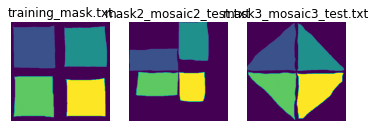

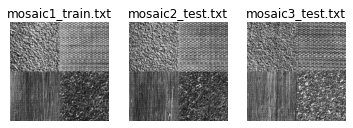

In [5]:
#Masks
m_files = ["training_mask.txt", "mask2_mosaic2_test.txt", "mask3_mosaic3_test.txt"]
figM, axsM = plt.subplots(1,3)

for file,i in zip(m_files, range(len(m_files))):
    axsM[i].imshow(np.loadtxt(file, delimiter=','))
    axsM[i].axis('off')
    axsM[i].set_title(file)
plt.show()

#Test/Train
t_files = ["mosaic1_train.txt", "mosaic2_test.txt", "mosaic3_test.txt"]
figT, axsT = plt.subplots(1,3)

for file,i in zip(t_files, range(len(t_files))):
    axsT[i].imshow(np.loadtxt(file, delimiter=','), cmap=plt.cm.gray)
    axsT[i].axis('off')
    axsT[i].set_title(file)
plt.show()


261633it [00:04, 63605.22it/s] 
261633it [00:02, 110377.42it/s]
261633it [00:02, 110291.89it/s]
261633it [00:02, 109745.98it/s]
261633it [00:02, 104332.81it/s]
261633it [00:02, 110357.12it/s]
261633it [00:02, 106658.12it/s]


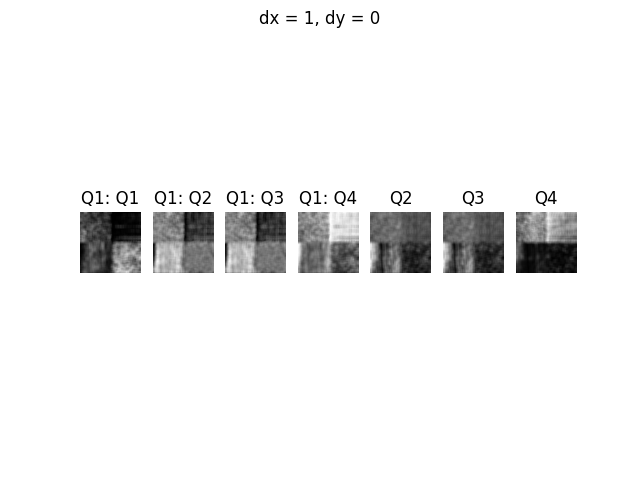

In [6]:
from glcm import compute_quadrant_features, quadruant
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

image = np.loadtxt("mosaic1_train.txt", delimiter=',')

feature_maps = []
num_features = 7
quad_names = ["Q1: Q1", "Q1: Q2", "Q1: Q3", "Q1: Q4", "Q2", "Q3","Q4"]

for i in range(num_features):
    feature_maps.append(compute_quadrant_features(image.copy(), window_size=31, dx=1, dy=0, gray_levels=16,quadrant=i+1))

dir_fig, dir_axs = plt.subplots(1,7)

dir_fig.suptitle(f"dx = {1}, dy = {0}")
for f,i in zip(feature_maps, range(num_features)):
    dir_axs[i].imshow(f, cmap=plt.cm.gray)
    dir_axs[i].axis('off')
    dir_axs[i].set_title(f"{quad_names[i]}")
plt.show()


### Discussion
I choose to visualize the different training and testing masks/images. That is the first bit of code. Moreover i used the glcm functon from the previous assignment, glcm.py. I also choose to implement "compute_quadrant_features" which basically is a copy of the "compute_glcm_features". I also implemented "quadrant" in this glcm.py. But i've pasted it below if you want to have a look without needing to open glcm.py.

The figure shows feature map for each of the quadrants, in total 7. We can observe that some of the feature maps are identical (this was mentioned above). I feel that the quadrants i wanted to use from step 2 actually looks like they could work fine, i.e. Q1:Q1, Q1:Q2 Q1:Q4, Q3 and Q4. They all have different feature maps which is what we want.

In [7]:
## CODE CREATED FOR ASSIGMENT 2 in glcm.py ##
# def compute_quadrant_features(image, window_size, dy, dx, gray_levels, quadrant):
#     feature_image = np.zeros(image.shape)
#     quantized = requantize(image, gray_levels)

#     for x, y, window in tqdm(SlidingWindowIter(quantized, window_size)):
#         matrix = glcm(window, dy, dx, gray_levels)
#         feature_image[y, x] = quadruant(matrix, quadrant)
#     return feature_image


# @jit(nopython=True)
# def quadruant(glcm, quadrant=1):
#     norm = (np.sum(glcm[:8,:8])+np.sum(glcm[8:,:8])+np.sum(glcm[8:,8:]))
#     sub = glcm[:8,:8]

#     if quadrant == 1:
#         return np.sum(sub[:4,:4])/np.sum(sub)
#     if quadrant == 2:
#         #sub Q2 of original Q1
#         return np.sum(sub[:4,4:])/np.sum(sub)
#     if quadrant == 3:
#         #sub Q3 of original Q1
#         return np.sum(sub[4:,:4])/np.sum(sub)
#     if quadrant == 4:
#         #sub Q4 of original Q1
#         return np.sum(sub[4:,4:])/np.sum(sub)
#     if quadrant == 5:
#         return np.sum(glcm[:8,8:])/norm
#     if quadrant == 6:
#         return np.sum(glcm[8:,:8])/norm
#     if quadrant == 7:
#         return np.sum(glcm[8:, 8:])/norm


## 4. Implement a multivariate Gaussian classifier

The classifier can and should use library functions for matrix inversion and computing the determinant. If you want, you can use library functions for estimating the mean vector and the covariance matrix. However, you must implement the computation of the posterior probability using Bayes rule yourself. Include the classifier code below.  

In [8]:
def train(classes, mask, features):
    num_features = len(features)
    num_classes = len(classes)

    mean_vector = np.zeros((num_classes, num_features))# Mean vector has size 1xn, where n is amount of features per class
    covar = np.zeros((num_classes, num_features, num_features))# Covariance matrix has size nxn, where n is the amount of features per class

    #Calculate for one class
    for i in range(num_classes):
        match = mask == classes[i]
        Xm = np.zeros((num_features, np.count_nonzero(match))) #Create an feature vector with size num_featuresXnum_matched_pixels
        index = np.nonzero(match) #Indexes of pixels matching class
        
        #Find class matches in all features
        for feature,j in zip(features, range(num_features)):
            Xm[j] = feature[index]
        
        #Estimate Gaussian parameters.
        covar[i] = np.cov(Xm)
        mean_vector[i] = np.mean(Xm, axis=1) #axis=1 calculates the rows

    return covar, mean_vector

In [9]:
from numba import jit

@jit (nopython=True)
def predict(x, parameters, classes):
    N,M,_ = x.shape
    num_classes = len(classes)
    covar, mean_vector = parameters
    prediction = np.zeros((N,M))
    postprior = np.zeros((num_classes))

    det = np.zeros((num_classes))
    inv = np.zeros(covar.shape)

    #Find prior probabilites assuming uniforms priors (no given information)
    prior = 1 / len(classes)

    #Calculate determinat and inverse covar for each class
    for i in range(num_classes):
        det[i] = np.linalg.det(covar[i])
        inv[i] = np.linalg.inv(covar[i])

    # For all pixels in the new image
    for n in range(N):
        for m in range(M):
            #Calculate the probability for this pixel being in each class
            for i in range(num_classes):
                X = x[m,n]-mean_vector[i]
                arg1 = 1 / (np.sqrt(2 * np.pi)**2 * np.sqrt(det[i]))
                arg2 = (-(1/2 * np.transpose(X)) @ inv[i] @ X) * prior
                
                postprior[i] = arg1*np.exp(arg2)
            
            prediction[m,n] = classes[np.argmax(postprior)]
                
    return prediction.T

## 5. Training the classifier based on the feature subset from point 3. 

Compute the overall classification accuracy and the full confusion matrix based on the training data. Discuss the performance, what does the confusion matrix show?
(Hint: if you run into a singular covariance matrix using a certain combination of features, there might be a reason for that. Try to understand why. If you don’t run into singular matrices you feature selection has avoided this little “trap”.)

Include the results and discussion below.


In [10]:
from glcm import compute_quadrant_features, quadruant

#Calculates the feature maps with features from task 3
def choose_features(image):
    features = []
    for i in [1, 2, 4, 6, 7]:
        features.append(compute_quadrant_features(image.copy(), window_size=31, dx=1, dy=0, gray_levels=16,quadrant=i))
    return features

#Converts axis to use in prediction
def find_x(features):
    return np.moveaxis(features, (0,1,2),(2,1,0))

In [11]:
#Find all classes
training_mask = np.loadtxt("training_mask.txt", delimiter=',')
training_image = np.loadtxt("mosaic1_train.txt", delimiter=',')

training_features = choose_features(training_image)
training = find_x(training_features)

classes = np.unique(training_mask).astype(int)[1:]

261633it [00:02, 123022.52it/s]
261633it [00:02, 122487.79it/s]
261633it [00:02, 104817.70it/s]
261633it [00:03, 83764.02it/s] 
261633it [00:02, 103649.86it/s]


In [12]:
#Train the model
parameters = train(classes, training_mask, training_features)


In [13]:
#Classify training image
train_pred = predict(training, parameters, classes)

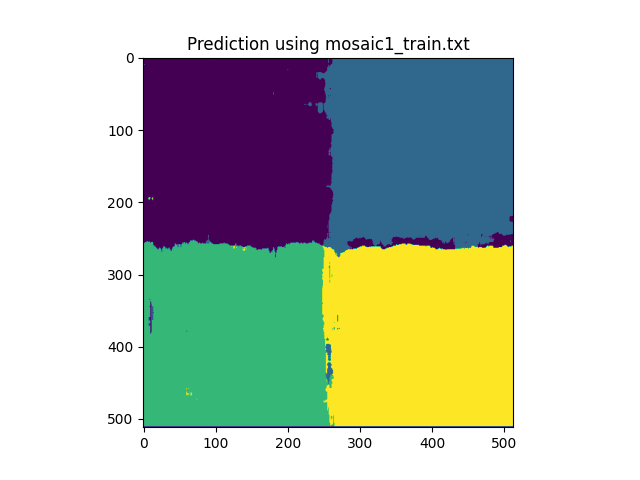

In [14]:
#Visual of the prediction made 
plt.figure()
plt.title("Prediction using mosaic1_train.txt")
plt.imshow(train_pred)
plt.show()

In [15]:
#Create evaluation function
from itertools import accumulate
from sklearn import metrics

def evaluation(ground_truth, prediction):

    index = np.flatnonzero(ground_truth)
    y_true = ground_truth.flatten()[index]
    y_pred = prediction.flatten()[index]

    confusion = metrics.confusion_matrix(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    return confusion, accuracy*100

def print_confusion(cm,classes):
    print("\tConfusion matrix:")
    for i in range(len(classes)):
        print(f"label {classes[i]}: {cm[i]}")

In [16]:
#Evaluation the prediction made from training 
train_confusion, train_accuracy = evaluation(training_mask, train_pred)

print(f"Accuracy: {round(train_accuracy,2)}%")
print()
print_confusion(train_confusion,classes)


Accuracy: 99.98%

	Confusion matrix:
label 1: [44866     4     0     0]
label 2: [    0 43057     0     0]
label 3: [    1     0 41088    22]
label 4: [    0     0     0 37215]


### Results/Discussion

Accuracy is defined as 

- accuracy = (True_positive + True_negative )/ (True_positive+True_negative+False_positive+False_negative)
  - True positive: How many times did the model correctly classify a Positive sample as Positive
  - False negative: How many times did the model incorrectly classify a Positive sample as Negative
  - False positive: How many times did the model incorrectly classify a Negative sample as Positive
  - True negative: How many times did the model correctly classify a Negative sample as negative
  - These values are given by comparing against different masks (ground truth)
  
In this case we have a very high accuracy of 99.98%. The training mask has some 0 values between each texture and the rest of the labels are inside each quadrant. We can observe that all the correct labels are in the correct quadrant with little noise (there are some, i.e. in the rand). The high accuracy is expected due to us using the training predictions. THis means we are using the same data as we trained the model with.

Moreover, this leads to the model making very little mistakes when classifing a pixel. This can be seen by looking at the confusion matrix. Each "pair" of row and column corresponds to a label. The diagonal is therefore the amount of true positives made by our classifier. Some pixels are wrong, for example looking at label 3, where 1 pixel is wrongly classified as label 1 and 22 as label 4.

## 6. Evaluation of classification performance on the test data set using the set of features selected in point 3. 

Now compute the overall classification accuracy and the confusion matrix on the two test images. These images are slightly different from the training image. Include the results and some discussion below. 

Compute the accuracy both on mosaic2_test.mat and mosaic3_test.mat using the corresponding test masks mask_mosaic2_test.mat and mask_mosaic3_test.mat. Compare the performance, and discuss the differences in accuracy you see.

In [17]:
#Mosaic test image 1
testing_image1 = np.loadtxt("mosaic2_test.txt", delimiter=',')
testing_features1 = choose_features(testing_image1)
test1 = find_x(testing_features1)

261633it [00:02, 115509.66it/s]
261633it [00:02, 108564.53it/s]
261633it [00:02, 126367.71it/s]
261633it [00:01, 130932.61it/s]
261633it [00:02, 106981.95it/s]


In [18]:
#Mosaic test image 1
testing_image2 = np.loadtxt("mosaic3_test.txt", delimiter=',')
testing_features2 = choose_features(testing_image2)
test2 = find_x(testing_features2)

261633it [00:02, 100469.93it/s]
261633it [00:02, 102646.09it/s]
261633it [00:02, 106486.20it/s]
261633it [00:02, 116796.37it/s]
261633it [00:02, 110316.00it/s]


In [19]:
#Test predictions
test1_pred = predict(test1, parameters, classes)
test2_pred = predict(test2, parameters, classes)

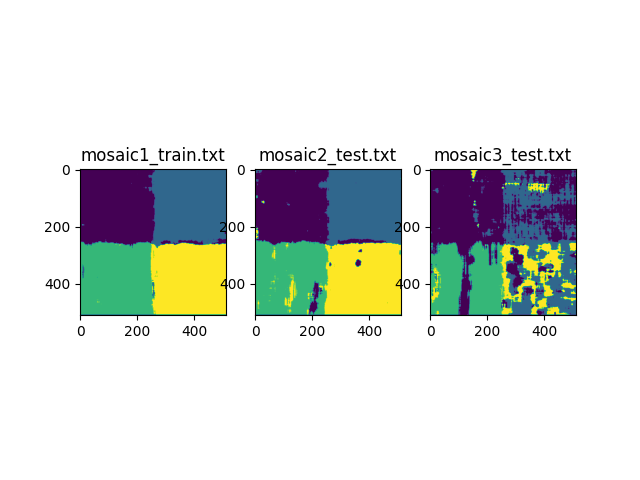

In [20]:
#Visualize the predictions
pred_fig, pred_axs = plt.subplots(1,3)

pred_axs[0].imshow(train_pred)
pred_axs[0].set_title("mosaic1_train.txt")

pred_axs[1].imshow(test1_pred)
pred_axs[1].set_title("mosaic2_test.txt")

pred_axs[2].imshow(test2_pred)
pred_axs[2].set_title("mosaic3_test.txt")

plt.show()

In [21]:
#Evaluation the prediction made from mosaic2_test.txt 
test1_mask = np.loadtxt("mask2_mosaic2_test.txt", delimiter=',')

test1_confusion, test1_accuracy = evaluation(test1_mask, test1_pred)

print(f"Accuracy: {round(test1_accuracy, 2)}%")
print()
print_confusion(test1_confusion,classes)

Accuracy: 98.08%

	Confusion matrix:
label 1: [26845    41    37   225]
label 2: [   73 29353     0     0]
label 3: [  148    12 24221   645]
label 4: [  540   213     3 18535]


In [22]:
#Evaluation the prediction made from mosaic3_test.txt 
test2_mask = np.loadtxt("mask3_mosaic3_test.txt", delimiter=',') 
test2_confusion, test2_accuracy = evaluation(training_mask, test2_pred)

print(f"Accuracy: {round(test2_accuracy, 2)}%")
print()
print_confusion(test2_confusion,classes)

Accuracy: 67.58%

	Confusion matrix:
label 1: [43214  1412     4   240]
label 2: [19545 21662     0  1850]
label 3: [ 6809   160 33366   776]
label 4: [ 5721 17374     8 14112]


### Results/Discussion

#### mosiac2_test.txt
In this case we also have a high accuracy. By looking at the figure and comparing it to the mask used as ground truth (mask2_mosaic2_test.txt) one can observe that the labels are moved to different placed in the 2D-array (compared to our previous analysis). We have ~2% poorer classification, this means we have more pixels that have been labeled wrongly. THis can be seen in the confusion matrix. In this case we have also used a different dataset (mosaic2_test.txt) when predicting. The difference from the train data, that i can observe by looking at the image, is that the lighting has changed in textures. Additionally texture 3 has changed abit (more curved)

Taking this into account i think this was a good result

#### mosiac2_test.txt
This result has a low accuracy and by inspecting the resulting figure this can be understood. We have alot of labels being classified wrong. THere is alot of noise and texture 4 and 2 is almost not found at all.

We used a different image for predicting here aswell. The lighting has increased even more, which results in texture 4 almost looking like a different texture. Texture 2 has actually gotten darker. I also looks like texture 2 is rotated. 

The labels being wronly classified can be seen in the confusion matrix. For example label 2 has classified pixels to the wrong label more than 50%. 